<a href="https://colab.research.google.com/github/UtwoA/Introduction_to_ML/blob/main/pr5part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('population.txt', sep='\t', encoding='cp1251')

df = df.rename(columns={
    'Численность населения (тыс. чел.)':'population_k',
    'Удельный вес городского населения %':'urban_pct',
    'Изменение численности населения':'pop_change_pct',
    'Среднегодовая численность населения занятых в экономике  (тыс. чел.)':'employed_k',
    'Среднедушевые денежные доходы (руб./мес.)':'income_rub',
    'Регион':'region'
})

In [ ]:
df = df.set_index('region')

fields = ['urban_pct','pop_change_pct','employed_k','income_rub']

In [ ]:
def clean_numbers(series):
    return (
        series.astype(str)
        .str.replace("−", "-", regex=False)
        .str.replace(",", ".", regex=False)
        .str.replace(" ", "", regex=False)
        .str.strip()
    )

for col in fields:
    df[col] = clean_numbers(df[col])
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [ ]:
smoothed = df.copy()

smoothed['income_rub'] = smoothed['income_rub'].replace(0, np.nan)
smoothed.loc[smoothed['pop_change_pct'].abs() > 50, 'pop_change_pct'] = np.nan

for col in fields:
    smoothed[col] = smoothed[col].fillna(smoothed[col].median())

In [ ]:
def winsorize(s, q1=0.01, q2=0.99):
    lo = s.quantile(q1)
    hi = s.quantile(q2)
    return s.clip(lower=lo, upper=hi)

for col in fields:
    smoothed[col] = winsorize(smoothed[col])

In [ ]:
scaler = StandardScaler()
X_smoothed = scaler.fit_transform(smoothed[fields])

In [ ]:
def cluster_and_profile(X, data, k):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    data_clust = data.copy()
    data_clust['cluster'] = labels

    means = data_clust.groupby('cluster')[fields].mean()
    counts = data_clust.groupby('cluster').size()

    cis = {}
    for c, subset in data_clust.groupby('cluster'):
        cis[c] = {}
        for col in fields:
            vals = subset[col].values
            mean = vals.mean()
            se = stats.sem(vals)
            h = se * stats.t.ppf(0.975, len(vals)-1)
            cis[c][col] = (mean-h, mean+h)

    f_vals, p_vals = f_classif(data[fields], labels)
    importance = pd.DataFrame({
        "feature": fields,
        "F": f_vals,
        "p": p_vals
    }).sort_values("F", ascending=False)

    return {
        "labels": labels,
        "means": means,
        "counts": counts,
        "cis": cis,
        "importance": importance,
        "df": data_clust
    }

In [ ]:
res5 = cluster_and_profile(X_smoothed, smoothed, 4)

print("\n=== ПРОФИЛИ КЛАСТЕРОВ (k=5) ===")
print(res5["means"])

print("\n=== ВАЖНОСТЬ ПРИЗНАКОВ ===")
print(res5["importance"])


=== ПРОФИЛИ КЛАСТЕРОВ (k=5) ===
         urban_pct  pop_change_pct   employed_k   income_rub
cluster                                                     
0        61.441333       -0.643133   452.586667  1167.913333
1        80.155556       -1.188889   672.288889  3039.481333
2        77.855556       -0.399444  1632.270667  1144.461111
3        45.700000       -7.160000    21.212000   711.964000

=== ВАЖНОСТЬ ПРИЗНАКОВ ===
          feature          F             p
1  pop_change_pct  60.691068  4.550799e-21
3      income_rub  46.891263  5.599643e-18
2      employed_k  46.744829  6.079647e-18
0       urban_pct   9.954601  1.081504e-05


In [ ]:
means = res5["means"]
overall_means = smoothed[fields].mean()
stds = smoothed[fields].std()

clusters_with_income = []
for c in means.index:
    diffs = (means.loc[c] - overall_means).abs() / stds
    if diffs.idxmax() == "income_rub":
        clusters_with_income.append(c)

print("\nКластеры, где доход — главный признак:", clusters_with_income)



Кластеры, где доход — главный признак: [1]


In [ ]:
pos_clusters = []
neg_clusters = []

for c in res5["means"].index:
    lo, hi = res5["cis"][c]["pop_change_pct"]
    if lo > 0:
        pos_clusters.append(c)
    if hi < 0:
        neg_clusters.append(c)

print("\nКластеры с положительным ростом населения:", pos_clusters)
print("Кластеры со снижением населения:", neg_clusters)


Кластеры с положительным ростом населения: []
Кластеры со снижением населения: [0, 1, 2]


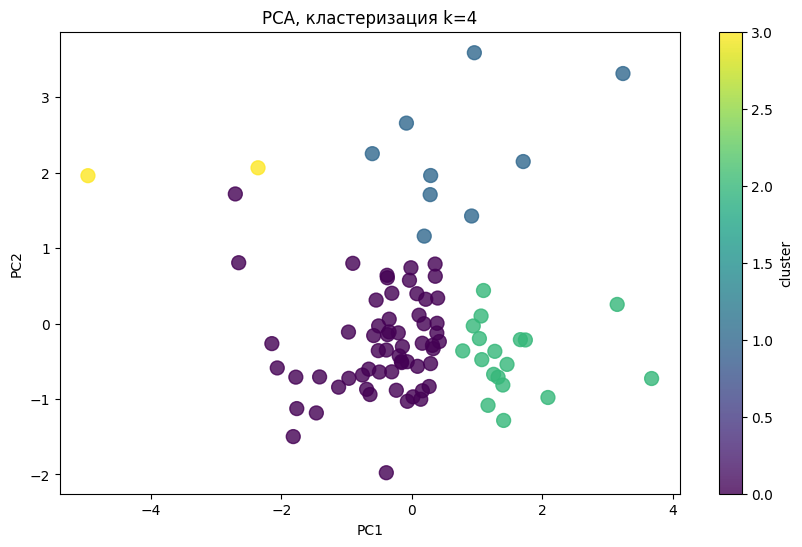

In [ ]:
pca = PCA(n_components=2)
Xp = pca.fit_transform(X_smoothed)

plt.figure(figsize=(10,6))
plt.scatter(Xp[:,0], Xp[:,1], c=res5["labels"], s=100, alpha=0.8)
plt.title("PCA, кластеризация k=4")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="cluster")
plt.show()

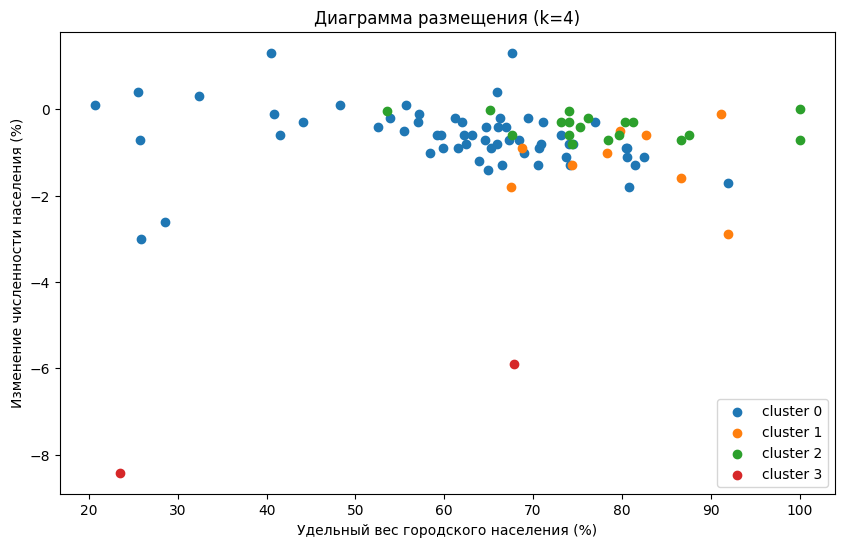

In [ ]:
plt.figure(figsize=(10,6))
for c in means.index:
    mask = res5["labels"] == c
    plt.scatter(
        smoothed.loc[mask,"urban_pct"],
        smoothed.loc[mask,"pop_change_pct"],
        label=f"cluster {c}"
    )
plt.xlabel("Удельный вес городского населения (%)")
plt.ylabel("Изменение численности населения (%)")
plt.title("Диаграмма размещения (k=4)")
plt.legend()
plt.show()
